# CTM MILP Model Running Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint
import time

from ctmmodels.const import *
from ctmmodels.delaythroughput import DelayThroughputSimplex as ConflictModel
from ctmmodels.ringbarrier import DTSimplexRingBarrier as RBModel

In [2]:
IMAGE_PATH = 'graphs/'
DF_PATH = 'dataframes/'

**Notes on the models and parameters being used:**

* 2 separate formulations were made: 1 dealing with individual movements in the intersection, and another dealing with phases in the stoplight. The latter has 33% less binary variables, and thus performed better in basic tests.

* Saturation flow rate will be set to 600 vph instead of the 450 vph in the parent paper; this is so as to test both under and over saturated conditions.

* Traffic will be distributed evenly between the 3 possible turns (left, through, and right). This is based on previous tests where left was getting essentially 0 green time.

* Time range will be set to 60 seconds, or 30 time steps at 2 seconds per time step. Preliminary experiments show that 50 is the optimal cycle time for both delay and throughput (at demands ranging from 450 to 900 vph). *However*, previous tests on this model showed that no time was allotted to left turns when the cycle time was too small.

In [3]:
time_range = 30 # time steps
time_ticks = np.arange(0, time_range+1, 1)

parameters = {
    'r_left': 1.0/3.0,
    'r_through': 1.0/3.0,
    'r_right': 1.0/3.0,
    'sat_flow_rate': 1800,
    'time_range': time_range,
    'time_step': 2,
    'g_min': 6,
    'g_max': 20
}

# Varying parameters: demand, use_flow_weight, flow_weight, alpha

In [4]:
def run_model(demand, alpha=1, beta=0, gamma=0, log_output=True, preload=None):
    model = RBModel(
        demand=demand,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        preload=preload,
        **parameters
    )
    model.generate()
    runtime = model.solve(log_output=log_output)
    dfx, dfy, dfg = model.return_solution()
    dfparams = model.return_parameters()
    obj_values = model.return_objective_value()
    return dfx, dfy, dfg, dfparams, obj_values, runtime

## Intersection Cell Network

![title](img/4leg-intersection.png)

## Setting the path of cells to check

In [16]:
_approach = 0

_approach_terms = [
    'Left',
    'Through',
    'Right'
]

_cell_path = [
    (CELL_SOURCE,0,_approach),
    (CELL_NORMAL,0,_approach),
    (CELL_NORMAL,1,_approach),
    (CELL_NORMAL,2,_approach),
    (CELL_MOVEMENT,THROUGH_TURN,_approach),
    S_mapping((CELL_MOVEMENT,THROUGH_TURN,_approach))[0]
]

def movement_paths(approach):
    return [
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,LEFT_TURN,approach),
            S_mapping((CELL_MOVEMENT,LEFT_TURN,approach))[0]
        ],
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,THROUGH_TURN,approach),
            S_mapping((CELL_MOVEMENT,THROUGH_TURN,approach))[0]
        ],
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,RIGHT_TURN,approach),
            S_mapping((CELL_MOVEMENT,RIGHT_TURN,approach))[0]
        ]
    ]

## Comparing cell volumes

In [6]:
def plot_volume(dfx, cell_path, title, headless=True, filename='volume.png'):
    dfx_approach = pd.concat([
        dfx[dfx.cell == c].sort_values(by='timestep')
        for c in cell_path
    ]).pivot(index='timestep', columns='cell', values='volume')
    
    fig, axs = plt.subplots(1,2, figsize=(20,10))
    
    sns.lineplot(data=dfx_approach, ax=axs[0])
    sns.lineplot(data=dfx_approach.cumsum(), ax=axs[1])

    axs[0].set_title('Volume of cells')
    axs[0].set_xlabel('Timesteps')
    axs[0].set_ylabel('Instantaneous volume')
    axs[0].set_xticks(time_ticks, minor=True)

    axs[1].set_title('Volume of cells (cumulative)')
    axs[1].set_xlabel('Timesteps')
    axs[1].set_ylabel('Cumulative volume')
    axs[1].set_xticks(time_ticks, minor=True)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Comparing flows

In [7]:
def plot_flow(dfy, cell_path, title, headless=True, filename='flow.png'):
    dfy_approach = pd.concat([
        dfy[dfy.cell_from == c].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
        for c in cell_path
    ]).reset_index().pivot(index='timestep', columns='cell_from', values='flow')
    
    fig, axs = plt.subplots(1,2, figsize=(20,10))

    sns.lineplot(data=dfy_approach, ax=axs[0])
    sns.lineplot(data=dfy_approach.cumsum(), ax=axs[1])

    axs[0].set_title('Flow from cells')
    axs[0].set_xlabel('Timesteps')
    axs[0].set_ylabel('Instantaneous flow')
    axs[0].set_xticks(time_ticks, minor=True)

    axs[1].set_title('Flow from cells (cumulative)')
    axs[1].set_xlabel('Timesteps')
    axs[1].set_ylabel('Cumulative flow')
    axs[1].set_xticks(time_ticks, minor=True)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Comparing specific green time

In [8]:
all_phases = [intToBinTuple(x) for x in range(8)]
all_phases_labels = [
    "Left, Westbound",
    "Through, Eastbound",
    "Left, Southbound",
    "Through, Southbound",
    "Left, Eastbound",
    "Through, Westbound",
    "Left, Northbound",
    "Through, Northbound",
]

def plot_greentime(dfg, title, headless=True, filename='greentime.png'):
    dfg_map = dfg.pivot(index='timestep', columns='cell', values='is_green')

    fig, axs = plt.subplots(8,1,figsize=(18,18), sharey=True)

    for ndx, t in enumerate(all_phases):
        sns.lineplot(data=dfg_map[t], ax=axs[ndx])
        axs[ndx].text(0.01,.5,all_phases_labels[ndx],
            horizontalalignment='left',
            transform=axs[ndx].transAxes,
            fontsize='large')
        axs[ndx].set_xticks(time_ticks, minor=False)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Generating graphs for each model case

In [9]:
def generate_graphs(dfx, dfy, dfg, capacity, max_flow, demand, alpha, flow_weight, folder=''):
    cell_paths = movement_paths(_approach)
    
    for ndx, cellpath in enumerate(cell_paths):
        if dfx is not None:
            plot_volume(dfx,
                        cellpath,
                        '''Volume in cells at {} vph and {}% delay weight ({} turn)
                        (Cap: {:.2f}, Max Flow: {}, Flow Weight: {})'''
                            .format(demand, alpha*100, _approach_terms[ndx], capacity, max_flow, flow_weight),
                        filename=folder+'volumes/{}vph_{}alpha_{}flow_volume_{}.png'
                            .format(demand, alpha, flow_weight, _approach_terms[ndx].lower()))
        
        if dfy is not None:
            plot_flow(dfy,
                      cellpath,
                      '''Flow from cells at {} vph and {}% delay weight ({} turn)
                      (Cap: {:.2f}, Max Flow: {}, Flow Weight: {})'''
                          .format(demand, alpha*100, _approach_terms[ndx], capacity, max_flow, flow_weight),
                      filename=folder+'flows/{}vph_{}alpha_{}flow_flow_{}.png'
                          .format(demand, alpha, flow_weight, _approach_terms[ndx].lower()))
    
    if dfg is not None:
        plot_greentime(dfg,
                       '''Green times at {} vph and {}% delay weight
                       (Cap: {:.2f}, Max Flow: {}, Flow Weight: {})'''
                           .format(demand, alpha*100, capacity, max_flow, flow_weight),
                       filename=folder+'greentimes/{}vph_{}alpha_{}flow_greetime.png'
                           .format(demand, alpha, flow_weight))

In [10]:
def plot_obj_values(obj_values, title, xaxis, xlabel, headless=True, filename='obj.png'):
    fig, axs = plt.subplots(1,2,figsize=(20,10))

    axs[0].plot(xaxis, [x[0] for x in obj_values])
    axs[0].set_title("Computed total delay")
    axs[0].set_ylabel("Total vehicle delay (timesteps)")
    axs[0].set_xlabel(xlabel)

    axs[1].plot(xaxis, [x[1] for x in obj_values])
    axs[1].set_title("Computed total throughput")
    axs[1].set_ylabel("Total vehicle throughput (veh)")
    axs[1].set_xlabel(xlabel)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Saving dataframes

In [11]:
def save_df(df, filename):
    df.to_pickle(DF_PATH + filename + ".pkl")

## 1. Comparing Conflict and RB models

In [12]:
ctm = {
    (3, 0, 1): 0,
    (3, 1, 1): 0,
    (3, 2, 1): 1,
    (2, 0, 1): 1,
    (2, 1, 1): 1,
    (2, 2, 1): 0,
    (1, 0, 1): 0,

    (3, 0, 0): 11,
    (3, 1, 0): 11,
    (3, 2, 0): 12,
    (2, 0, 0): 4,
    (2, 1, 0): 3,
    (2, 2, 0): 4,
    (1, 0, 0): 0,

    (3, 0, 3): 0,
    (3, 1, 3): 0,
    (3, 2, 3): 1,
    (2, 0, 3): 1,
    (2, 1, 3): 0,
    (2, 2, 3): 1,
    (1, 0, 3): 0,

    (3, 0, 2): 11,
    (3, 1, 2): 11,
    (3, 2, 2): 12,
    (2, 0, 2): 3,
    (2, 1, 2): 6,
    (2, 2, 2): 3,
    (1, 0, 2): 0,
}

In [13]:
dfx, dfy, dfg, dfparams, obj_values, runtime = run_model(demand=600, alpha=0.4, beta=0.4, gamma=0.2, log_output=True, preload=None)

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 1520 rows and 292 columns.
MIP Presolve modified 692 coefficients.
Aggregator did 158 substitutions.
Reduced MIP has 3444 rows, 1890 columns, and 11812 nonzeros.
Reduced MIP has 270 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (12.64 ticks)
Found incumbent of value 913.976488 after 0.03 sec. (22.91 ticks)
Probing fixed 0 vars, tightened 132 bounds.
Probing time = 0.01 sec. (0.61 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 604 rows and 104 columns.
Aggregator did 88 substitutions.
Reduced MIP has 2752 rows, 1698 columns, and 10104 nonzeros.
Reduced MIP has 270 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.28 ticks)
Probing time = 0.01 sec. (0.43 ticks)
Tried aggregator 1 time.
Reduced MIP has 2752 rows, 1698 columns, and 10104 nonzeros.
Reduced MIP has 270 binaries, 0 generals, 0 SOSs, and 0 indicators.
P

In [14]:
#print(c_obj_values)
print(obj_values)

(1287.104078762307, 44.306610407876214, -55.109118922451536)


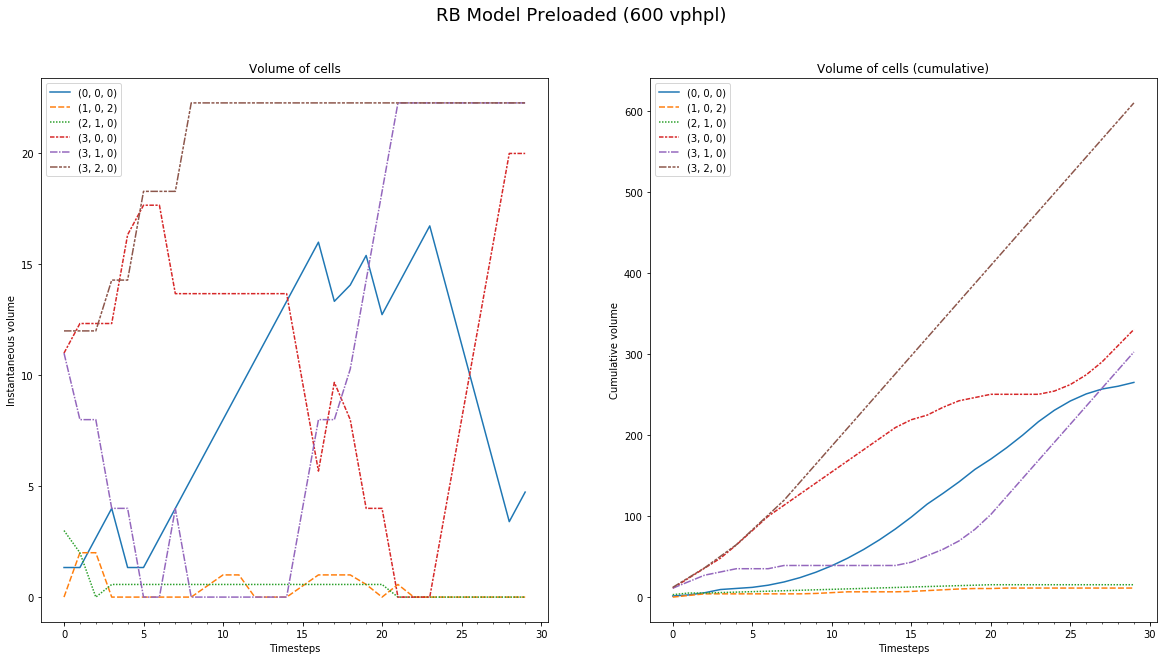

In [18]:
plot_volume(dfx, _cell_path, "RB Model Preloaded (600 vphpl)", headless=False, filename='flow.png')

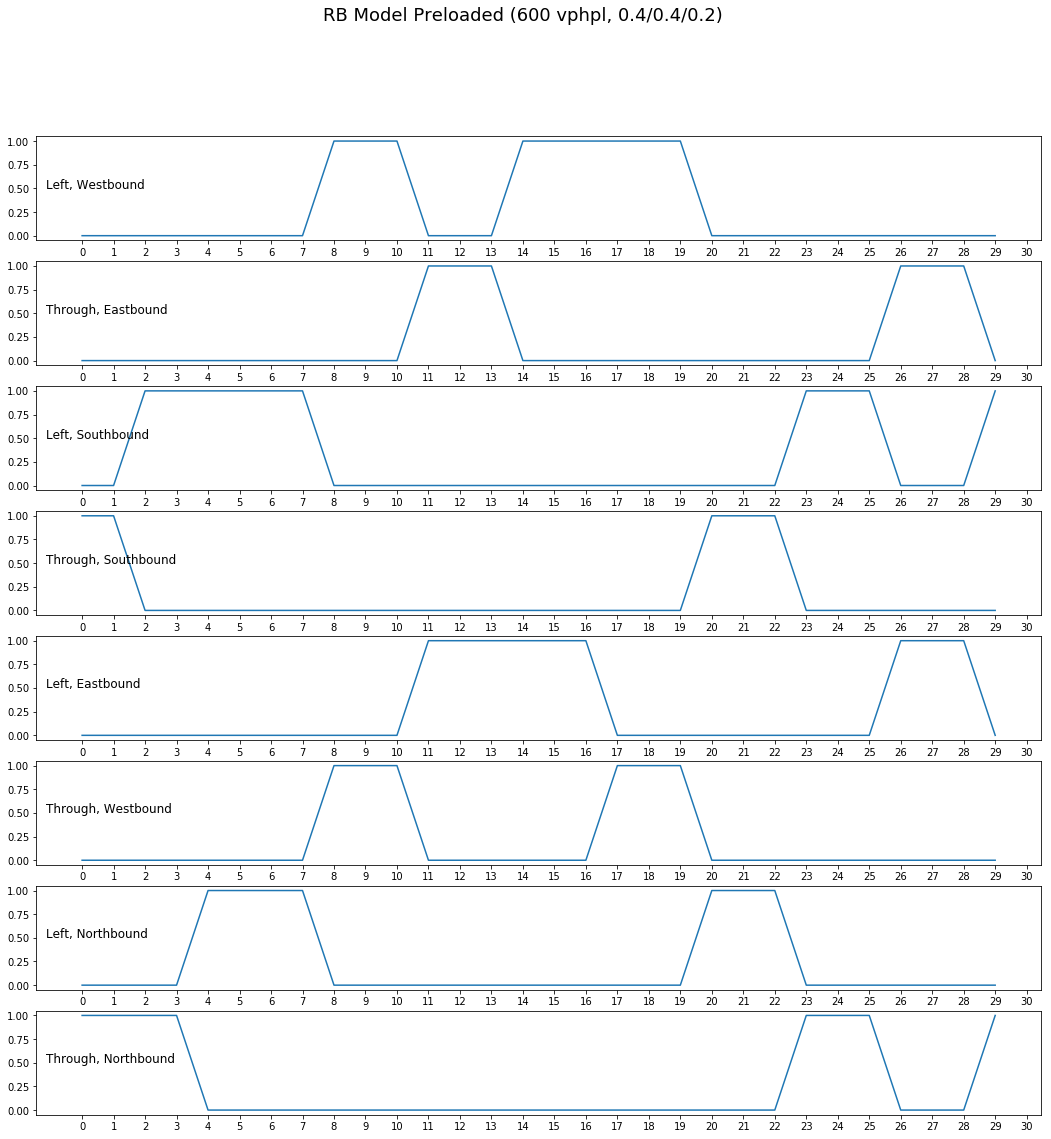

In [19]:
plot_greentime(dfg, "RB Model Preloaded (600 vphpl, 0.4/0.4/0.2)", headless=False)

In [13]:
dfx, dfy, dfg, dfparams, obj_values, runtime = run_model(demand=600, alpha=0.4, beta=0.4, gamma=0.2, log_output=True, preload=ctm)

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 3 times.
MIP Presolve eliminated 1213 rows and 164 columns.
MIP Presolve modified 741 coefficients.
Aggregator did 132 substitutions.
Reduced MIP has 3777 rows, 2044 columns, and 12630 nonzeros.
Reduced MIP has 270 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (13.81 ticks)
Found incumbent of value 1828.236225 after 0.04 sec. (29.74 ticks)
Probing fixed 0 vars, tightened 439 bounds.
Probing time = 0.00 sec. (0.78 ticks)
Cover probing fixed 0 vars, tightened 21 bounds.
Tried aggregator 2 times.
MIP Presolve eliminated 685 rows and 119 columns.
Aggregator did 103 substitutions.
Reduced MIP has 2989 rows, 1822 columns, and 10695 nonzeros.
Reduced MIP has 270 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (6.37 ticks)
Probing time = 0.00 sec. (0.46 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 3 rows and 3 columns.
Reduced MIP has 2986 rows, 1819 c

In [14]:
#print(c_obj_values)
print(obj_values)

(3953.043600562589, 47.55696202531645, 998.1407816875201)


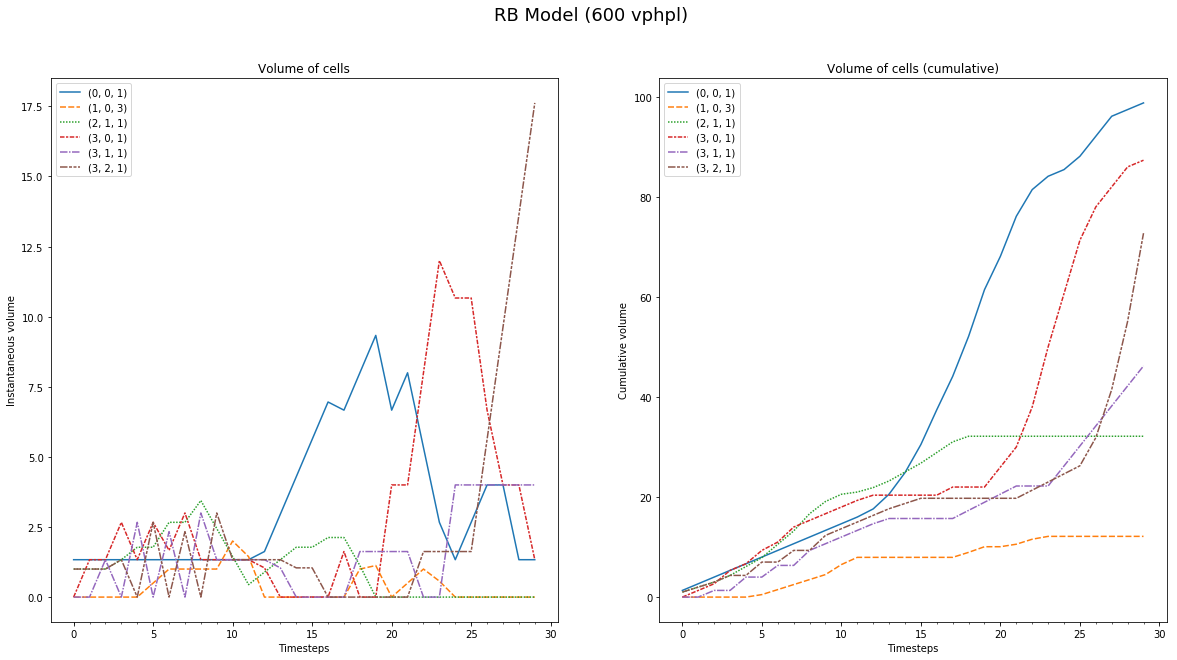

In [15]:
plot_volume(dfx, _cell_path, "RB Model (600 vphpl)", headless=False, filename='flow.png')

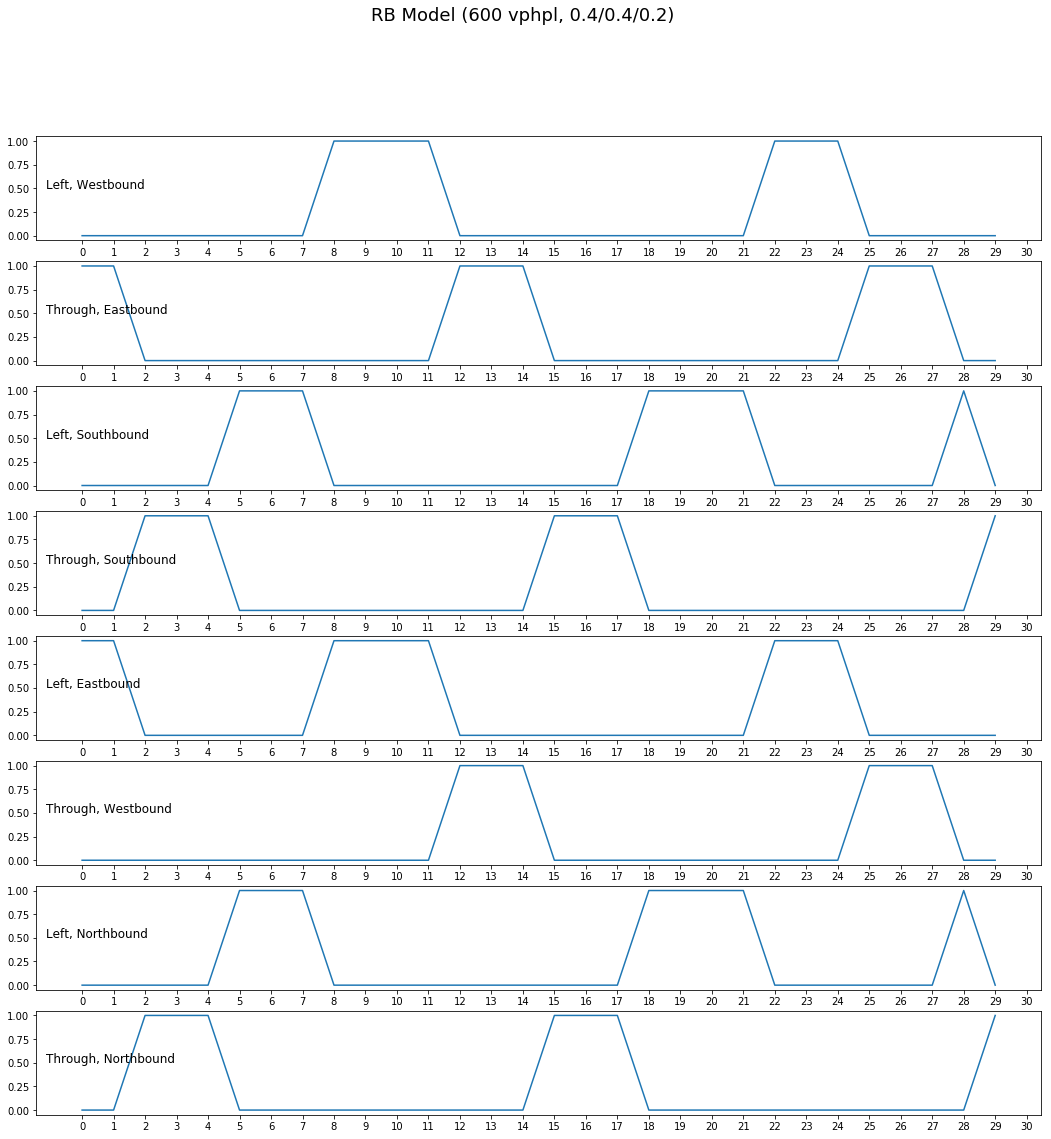

In [23]:
plot_greentime(dfg, "RB Model (600 vphpl, 0.4/0.4/0.2)", headless=False)